In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import pathlib
import pickle

sys.path.append('..')

In [3]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.patches as mpatches
from IPython.display import display, HTML
from loguru import logger

In [4]:
from pals.feature_extraction import DataSource
from pals.loader import GNPSLoader
from pals.PLAGE import PLAGE
from pals.common import *

2020-04-30 14:30:08.749 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


### Load GNPS results using the loader

In [5]:
database_name = DATABASE_GNPS
gnps_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f'

In [6]:
metadata_file = os.path.join('test_data', 'AGP', 'AG_Plants_extremes_metadata_df.csv')
metadata_df = pd.read_csv(metadata_file)
metadata_df

,sample,group
0,11337_P4_RE11_01_484.mzML,Less than 10
1,13313_P4_RE2_01_474.mzML,Less than 10
2,22510_P3_RG10_01_390.mzML,Less than 10
3,27840_P1_RG3_01_118.mzML,Less than 10
4,28742_P6_RH3_01_699.mzML,Less than 10
...,...,...
81,41935_P1_RG11_01_126.mzML,More than 30
82,42739_P3_RH1_01_395.mzML,More than 30
83,43160_P3_RE11_01_361.mzML,More than 30
84,49025_P6_RA4_01_676.mzML,More than 30


In [7]:
case = 'More than 30'
control = 'Less than 10'
comp_name = 'more_plants/no_plants'
comparisons = [{'case': case, 'control': control, 'name': comp_name },]
comparisons

[{'case': 'More than 30',
  'control': 'Less than 10',
  'name': 'more_plants/no_plants'}]

In [8]:
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons)
database = loader.load_data()

2020-04-30 14:30:09.095 | INFO     | pals.loader:_download_gnps:226 - Found GNPS task 0a8432b5891a48d7ad8459ba4a89969f
38.9MiB [00:14, 7.44MiB/s]2020-04-30 14:30:24.305 | DEBUG    | pals.loader:_parse_gnps:265 - Found cluster info: clusterinfo_summary/cffab31fda574b1f961b8b336a3fc9bd.tsv
2020-04-30 14:30:24.395 | DEBUG    | pals.loader:_parse_gnps:270 - Found quantification table: quantification_table/quantification_table-00000.csv
40.0MiB [00:14, 2.68MiB/s]


Create data source. For GNPS, we get *measurement_df*, *annotation_df* and *experimental_design* parameters from *database* before passing them to the *DataSource* constructor.

In [9]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']

In [10]:
measurement_df.head()

,11337_P4_RE11_01_484.mzML,13313_P4_RE2_01_474.mzML,22510_P3_RG10_01_390.mzML,27840_P1_RG3_01_118.mzML,28742_P6_RH3_01_699.mzML,30483_P1_GD1_01_145.mzML,37543_P6_RG2_01_695.mzML,37937_P6_RD2_01_686.mzML,38057_P5_RE1_01_602.mzML,38093_P5_RE5_01_606.mzML,...,41323_P1_RG12_01_127.mzML,41341_P2_RE8_01_224.mzML,41534_P6_RB1_01_677.mzML,41698_P3_RC9_01_329.mzML,41744_P6_RE1_01_688.mzML,41935_P1_RG11_01_126.mzML,42739_P3_RH1_01_395.mzML,43160_P3_RE11_01_361.mzML,49025_P6_RA4_01_676.mzML,5990_P2_RB6_01_175.mzML
peak_id,,,,,,,,,,,,,,,,,,,,,
1,16621.9880,7.116694e+04,6.055347e+05,1095.7485,1.140599e+06,14605.3060,4.579952e+04,1.098218e+06,9.364128e+03,1.653913e+04,...,1715.1885,1.936919e+06,1.551468e+05,8492.3235,2.391372e+05,94469.0770,1.985232e+06,3.165443e+05,291132.561,57110.3940
2,226.5455,1.566927e+04,5.025617e+04,395148.9380,1.934524e+05,142826.9005,4.360585e+02,1.532759e+05,2.788818e+04,1.289885e+04,...,145.8310,4.268199e+05,6.492751e+03,7720.6630,1.263886e+04,480.2375,5.066707e+05,1.663545e+04,20276.257,168.3725
3,992235.6470,1.293665e+06,1.181147e+06,0.0000,9.435760e+05,0.0000,1.147643e+06,9.106171e+05,1.458229e+06,1.350834e+06,...,0.0000,0.000000e+00,1.673888e+06,14355.9335,1.304436e+06,0.0000,1.380754e+06,1.227284e+06,1444913.288,0.0000
4,931484.0325,1.214219e+06,9.357495e+05,0.0000,7.189252e+05,145.0350,7.851636e+05,6.281846e+05,1.044920e+06,9.298224e+05,...,269.6995,0.000000e+00,1.086346e+06,7135.2980,9.033790e+05,694.5275,1.056104e+06,9.832828e+05,1043496.384,433.5000
5,810685.3930,8.649341e+05,4.130054e+05,2470.5085,7.716864e+05,2717.1375,6.570987e+05,4.635221e+05,8.705470e+02,1.174299e+03,...,2350.6205,1.245302e+03,1.519240e+06,709596.0825,1.246027e+06,2860.2950,2.444535e+06,4.618985e+05,1872717.354,3621.1830


In [11]:
annotation_df.head()

,entity_id
peak_id,
2,2
4,4
5,5
6,6
7,7


### Create data source and run PLAGE analysis

In [12]:
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database)

2020-04-30 14:30:25.255 | DEBUG    | pals.feature_extraction:__init__:45 - Using user-provided database
2020-04-30 14:30:25.256 | DEBUG    | pals.feature_extraction:__init__:53 - Mapping pathway to unique ids
2020-04-30 14:30:25.261 | DEBUG    | pals.feature_extraction:__init__:67 - Creating dataset to pathway mapping
2020-04-30 14:30:25.698 | DEBUG    | pals.feature_extraction:__init__:95 - Computing unique id counts


In [64]:
plage = PLAGE(gnps_ds, num_resamples=1000)
pathway_df = plage.get_pathway_df(standardize=True)

2020-04-30 15:57:06.072 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:303 - Setting the zero intensity values in the dataframe
2020-04-30 15:57:06.144 | DEBUG    | pals.feature_extraction:standardize_intensity_df:272 - Scaling the data across the sample: zero mean and unit variance
2020-04-30 15:57:06.198 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0.  0. -0. ...  0.  0. -0.]
2020-04-30 15:57:06.199 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-04-30 15:57:06.955 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2020-04-30 15:57:06.955 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparison more_plants/no_plants
2020-04-30 15:57:06.955 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:111 - Resampling 0/1000
2020-04-30 15:57:07.101 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:111 - Resampling 1

In [65]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
65,Molecular Family #65,0.0,81,81,100.0,1.0,81.0,100.0,NaN
21,Molecular Family #21,0.0,64,64,100.0,1.0,64.0,100.0,NaN
223,Molecular Family #223,0.0,46,46,100.0,1.0,46.0,100.0,NaN
590,Molecular Family #590,0.0,33,33,100.0,1.0,33.0,100.0,NaN
781,Molecular Family #781,0.0,27,27,100.0,1.0,27.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...
1063,Molecular Family #1063,1.0,2,2,100.0,1.0,2.0,100.0,NaN
3623,Molecular Family #3623,1.0,2,2,100.0,1.0,2.0,100.0,NaN
407,Molecular Family #407,1.0,2,2,100.0,1.0,2.0,100.0,NaN
2616,Molecular Family #2616,1.0,2,2,100.0,1.0,2.0,100.0,NaN


### Checking results

In [66]:
sns.set()

2020-04-30 15:57:20.189 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:303 - Setting the zero intensity values in the dataframe
2020-04-30 15:57:20.271 | DEBUG    | pals.feature_extraction:standardize_intensity_df:272 - Scaling the data across the sample: zero mean and unit variance


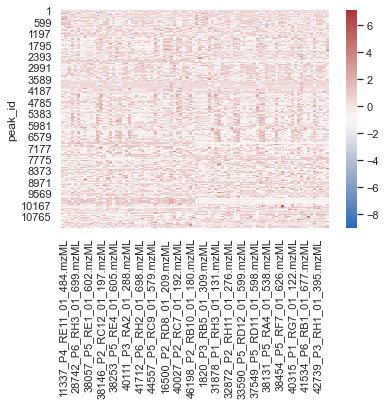

In [67]:
intensities_df = gnps_ds.standardize_intensity_df()
# cmap = 'RdBu_r'
# cmap = 'jet'
cmap = 'vlag'
sns.heatmap(intensities_df, cmap=cmap)

In [68]:
# pd.set_option('display.max_colwidth', None)

Filter significant molecular families by p-value. 

In [69]:
df = pathway_df[pathway_df[p_value_col] < 0.05]
df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
65,Molecular Family #65,0.000000,81,81,100.0,1.0,81.0,100.0,NaN
21,Molecular Family #21,0.000000,64,64,100.0,1.0,64.0,100.0,NaN
223,Molecular Family #223,0.000000,46,46,100.0,1.0,46.0,100.0,NaN
590,Molecular Family #590,0.000000,33,33,100.0,1.0,33.0,100.0,NaN
781,Molecular Family #781,0.000000,27,27,100.0,1.0,27.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...
2784,Molecular Family #2784,0.032586,2,2,100.0,1.0,2.0,100.0,NaN
2067,Molecular Family #2067,0.036073,2,2,100.0,1.0,2.0,100.0,NaN
539,Molecular Family #539,0.036567,4,4,100.0,1.0,4.0,100.0,NaN
918,Molecular Family #918,0.047324,2,2,100.0,1.0,2.0,100.0,NaN


Count how many significant molecular families having at least 10 members.

In [73]:
min_members = 10
df[df[count_col] >= min_members].shape

(34, 9)

Plot significant molecular families

In [21]:
all_samples = []
all_groups = []
for group in experimental_design['groups']:
    samples = experimental_design['groups'][group]
    all_samples.extend(samples)
    all_groups.extend([group] * len(samples))

In [22]:
entity_dict = gnps_ds.entity_dict

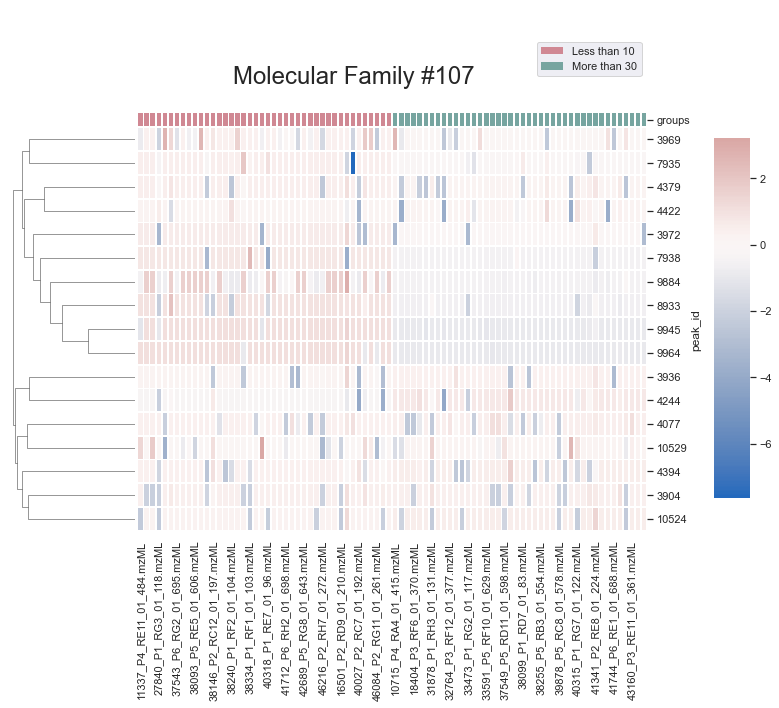

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3904,NaN,283.3850,6.6902,0.005757,62,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3936,NaN,281.3685,6.1956,0.003249,32,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3969,NaN,338.4474,7.5033,0.000626,67,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3972,NaN,257.3501,6.6157,0.003472,23,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4077,NaN,282.4009,5.9633,0.006391,72,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4244,NaN,281.3686,6.3773,0.002445,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4379,NaN,283.3875,6.8500,0.003451,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4394,NaN,311.4286,6.4895,0.003489,45,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4422,NaN,283.3847,7.0033,0.005851,42,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


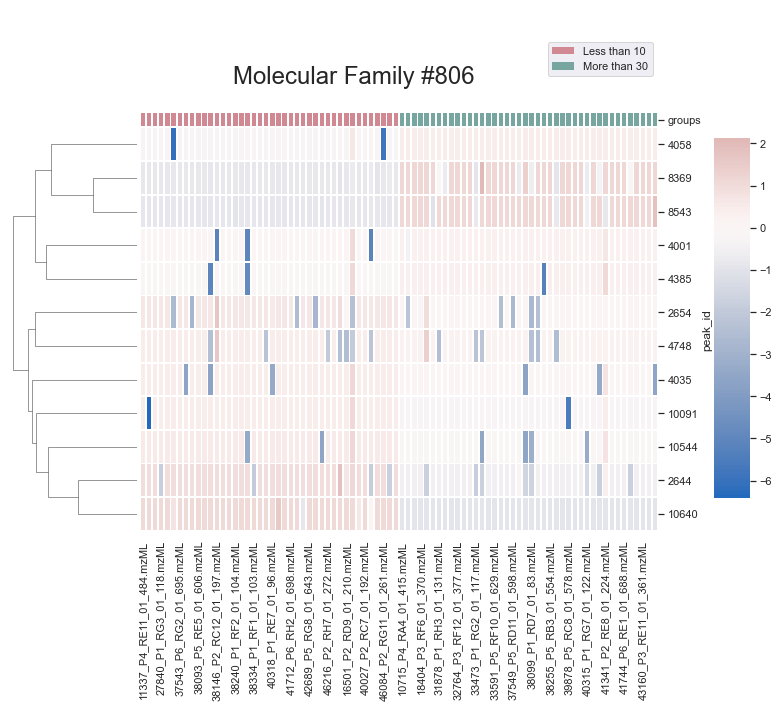

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2644,NaN,1124.1605,8.5465,0.000566,29,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2654,NaN,903.9793,10.0056,0.000990,27,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4001,NaN,859.9626,10.0235,0.002199,16,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4035,NaN,1036.1585,9.0462,0.004359,13,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4058,NaN,992.1095,9.2608,0.002155,6,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4385,NaN,859.9644,11.9278,0.000265,13,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4748,NaN,859.9639,8.4930,0.000479,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8369,NaN,903.9788,8.4826,0.000534,34,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8543,NaN,903.9978,8.9325,0.000714,29,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


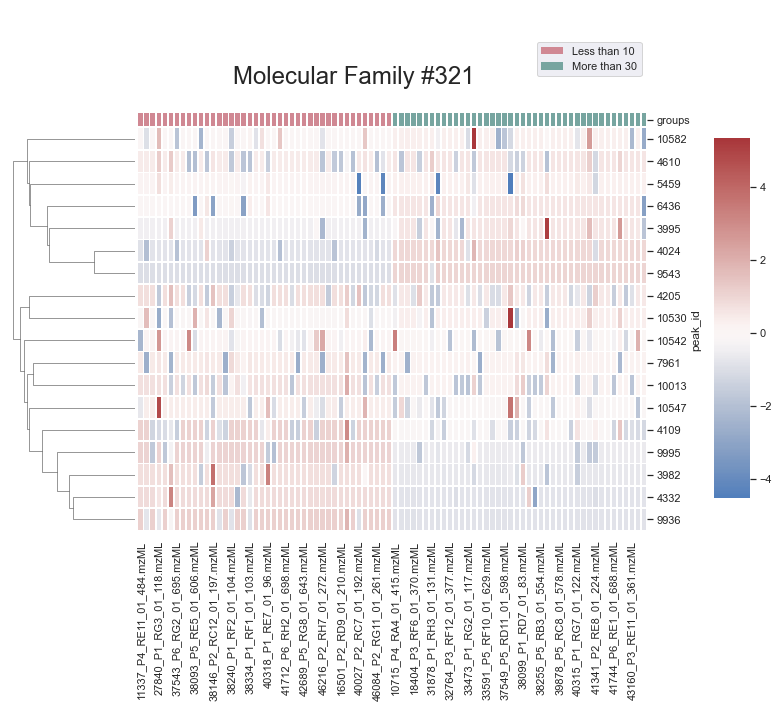

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3982,NaN,555.5876,7.3210,0.000320,35,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3995,NaN,643.6987,7.0987,0.000372,45,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4024,NaN,599.6433,7.2011,0.000340,35,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4109,NaN,731.8128,6.9741,0.000327,83,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4205,NaN,703.7633,6.4421,0.001639,83,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4332,NaN,599.6293,7.3056,0.000036,29,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4610,NaN,659.7178,6.7056,0.002516,64,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5459,NaN,615.6725,6.9738,0.009523,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6436,NaN,571.6270,7.0878,0.006691,50,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


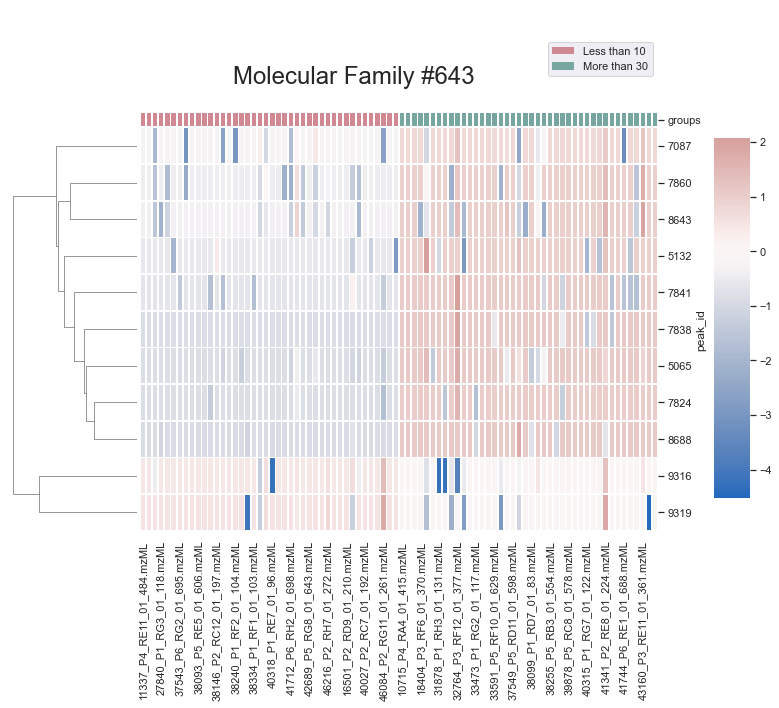

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
5065,NaN,323.4336,5.9353,0.002334,52,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5132,NaN,381.4641,6.3418,0.000442,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7087,NaN,303.3992,5.9393,0.017853,55,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7824,NaN,297.4073,5.6526,0.001456,22,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7838,NaN,379.4473,5.6911,0.000329,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7841,NaN,319.4008,5.7905,0.000260,26,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7860,NaN,321.4174,5.9831,0.001626,51,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8643,NaN,381.4643,5.9900,0.001490,53,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8688,NaN,265.3415,8.6238,0.000122,17,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


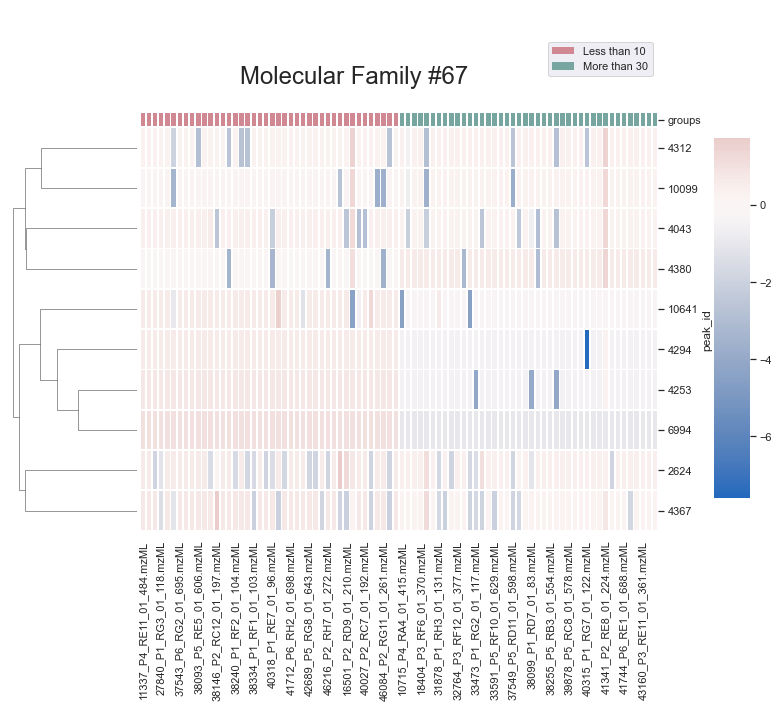

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2624,NaN,921.0067,8.5743,0.003687,66,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4043,NaN,965.0495,10.0136,0.002113,39,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4253,NaN,1053.1902,9.0329,0.001277,13,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4294,NaN,1009.1404,9.2584,0.000784,6,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4312,NaN,876.9944,10.0294,0.000550,33,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4367,NaN,921.0079,8.3927,0.001627,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4380,NaN,876.9954,11.9504,0.000202,17,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6994,NaN,1053.2073,10.1071,0.000022,12,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10099,NaN,877.9892,10.0095,0.000486,19,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


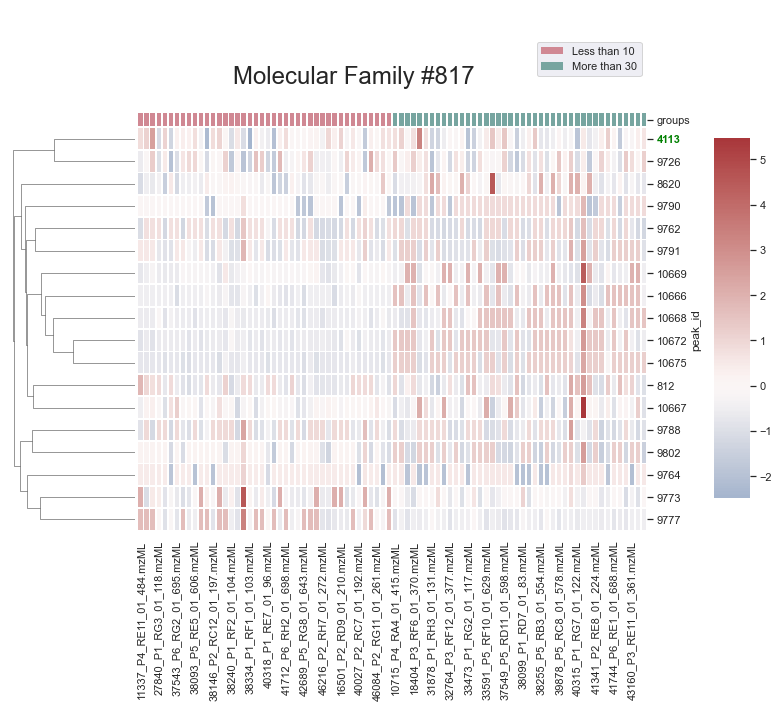

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
812,NaN,152.0707,1.0165,0.070058,170,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4113,Ethyl-4-dimethylaminobenzoate,194.1176,3.7475,0.002821,199,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8620,NaN,418.2589,3.0167,0.000853,169,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9726,NaN,195.1225,1.9348,0.003438,199,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9762,NaN,406.1045,3.1339,0.045299,91,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9764,NaN,811.2007,3.1452,0.011700,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9773,NaN,585.2114,3.2201,0.000573,116,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9777,NaN,642.2292,3.2443,0.000584,112,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9788,NaN,301.0821,2.8405,0.000898,103,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


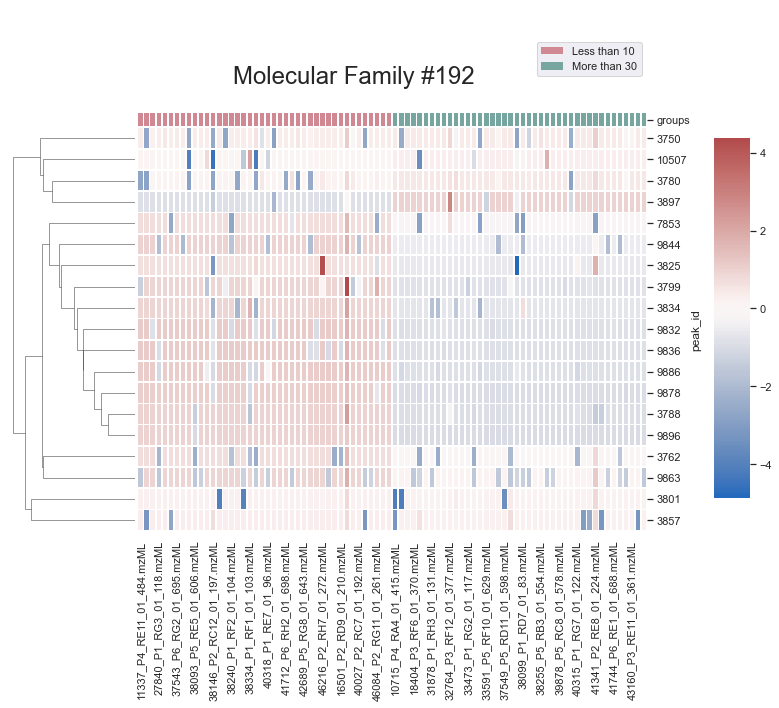

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3750,NaN,521.6287,5.9399,0.034883,80,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3762,NaN,505.6357,6.8835,0.007146,31,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3780,NaN,477.5840,6.0237,0.030437,56,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3788,NaN,493.4769,5.4585,0.001345,31,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3799,NaN,449.4522,5.4823,0.001204,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3801,NaN,433.5388,6.2075,0.011535,29,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3825,NaN,405.4277,5.5283,0.000956,23,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3834,NaN,417.5306,7.0496,0.001294,22,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3857,NaN,389.4941,6.4064,0.009078,26,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


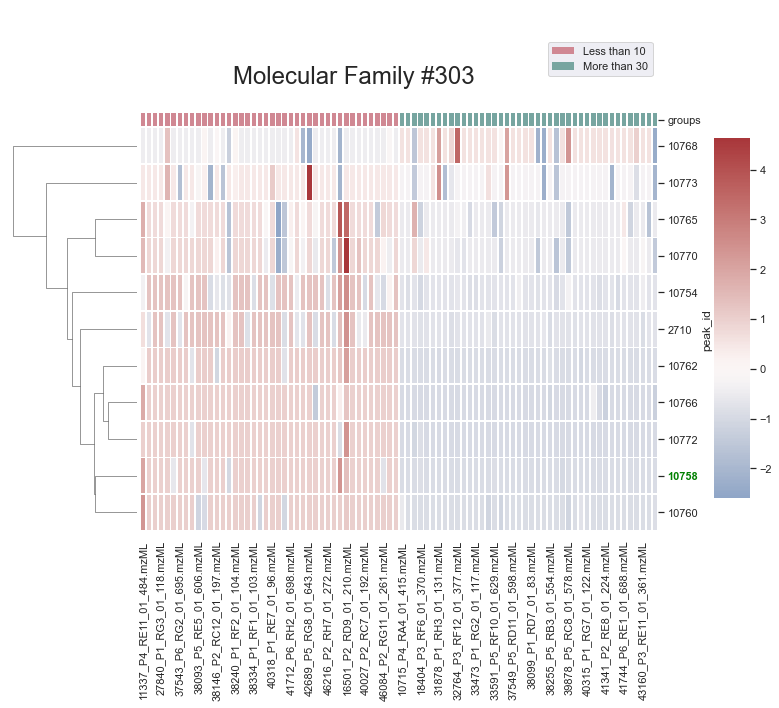

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2710,NaN,168.5963,3.0664,0.045834,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10754,NaN,175.5864,2.3527,0.002375,64,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10758,Spectral Match to Hydroxychloroquine from NIST14,168.5966,3.9622,0.000197,18,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10760,NaN,154.5808,2.9094,0.000266,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10762,NaN,146.5831,3.2355,0.000320,13,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10765,NaN,176.5941,3.2371,0.000101,52,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10766,NaN,146.5823,3.0754,0.000114,12,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10768,NaN,189.6019,3.2481,0.000139,61,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10770,NaN,176.5940,3.3145,0.000119,53,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


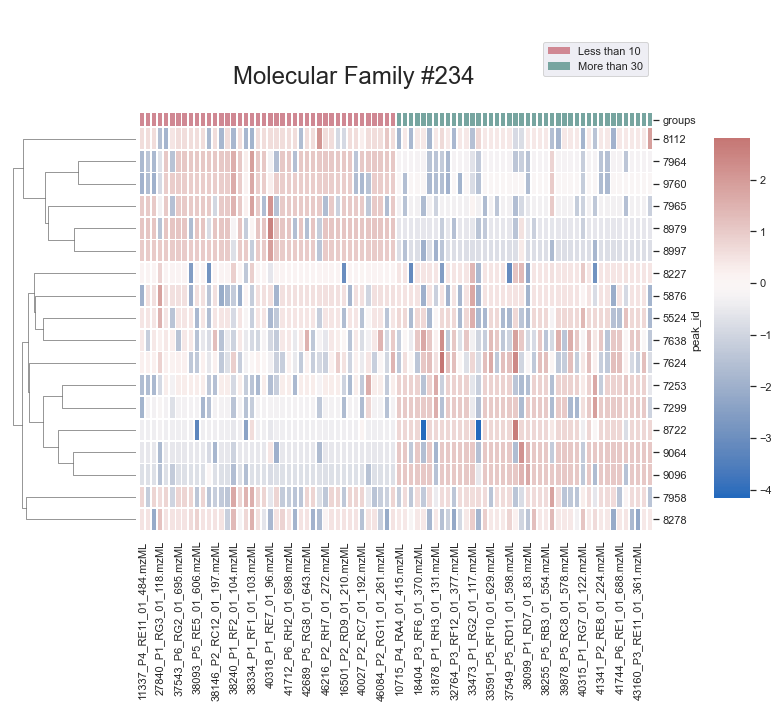

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
5524,NaN,908.7403,10.0396,0.001693,68,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5876,NaN,908.7406,11.9578,0.001017,50,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7253,NaN,864.7138,10.0463,0.000900,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7299,NaN,864.7137,11.9492,0.000680,55,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7624,NaN,908.7384,9.0309,0.002556,138,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7638,NaN,952.7638,8.9239,0.002463,139,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7958,NaN,952.7668,10.0495,0.001722,84,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7964,NaN,952.7667,11.9470,0.001348,62,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7965,NaN,996.7955,10.0508,0.000388,70,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


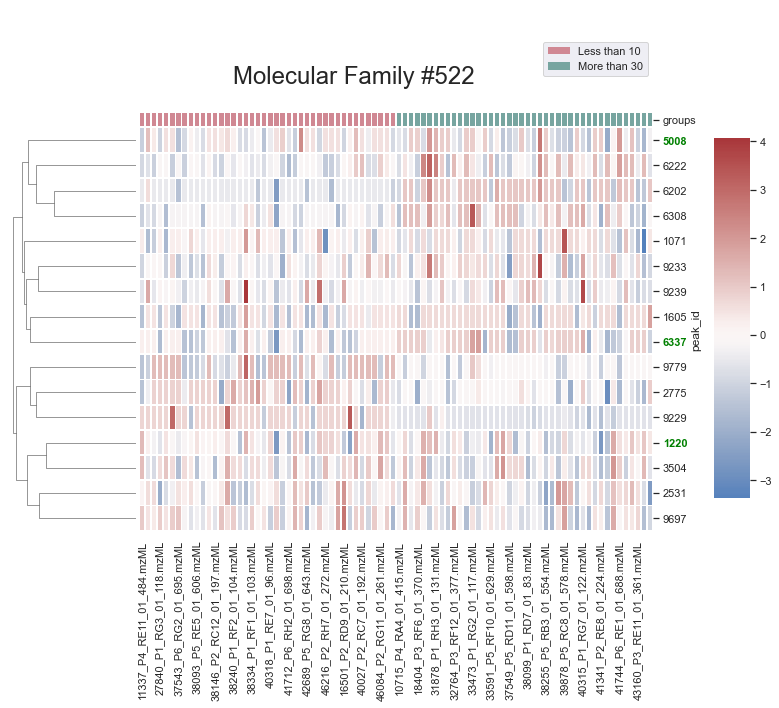

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1071,NaN,371.2571,4.4769,0.006413,105,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1220,"Cholest-4,6-Dien-3-One",383.3314,8.5501,0.015638,197,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1605,NaN,427.3405,6.5532,0.002157,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2531,NaN,357.2786,8.8207,0.004238,192,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2775,NaN,371.2562,4.7345,0.001963,104,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3504,NaN,399.3263,7.2462,0.002132,169,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5008,Spectral Match to 18.alpha.-Glycyrrhetinic aci...,471.3462,4.7158,0.006986,134,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6202,NaN,469.3300,4.8789,0.002373,59,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6222,NaN,457.3310,4.4194,0.000621,147,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


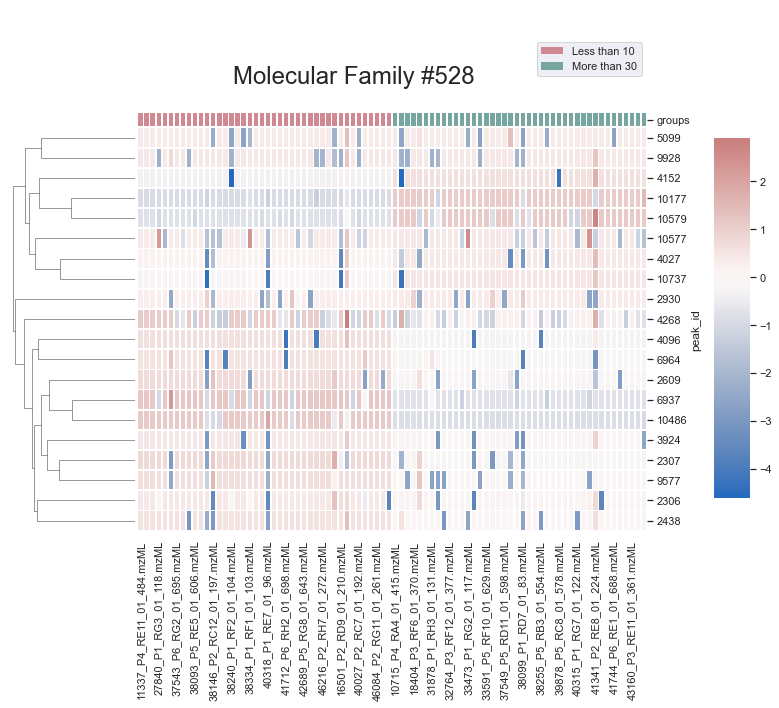

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2306,NaN,875.9381,8.5483,0.018316,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2307,NaN,964.0179,10.0215,0.001448,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2438,NaN,920.0013,10.0391,0.004572,31,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2609,NaN,920.0019,8.2465,0.002859,33,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2930,NaN,875.9356,10.0098,0.002383,50,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3924,NaN,831.9650,8.8444,0.007222,31,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4027,NaN,964.0387,9.9932,0.003077,27,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4096,NaN,920.0017,11.9699,0.001788,20,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4152,NaN,787.9126,9.1882,0.000531,14,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


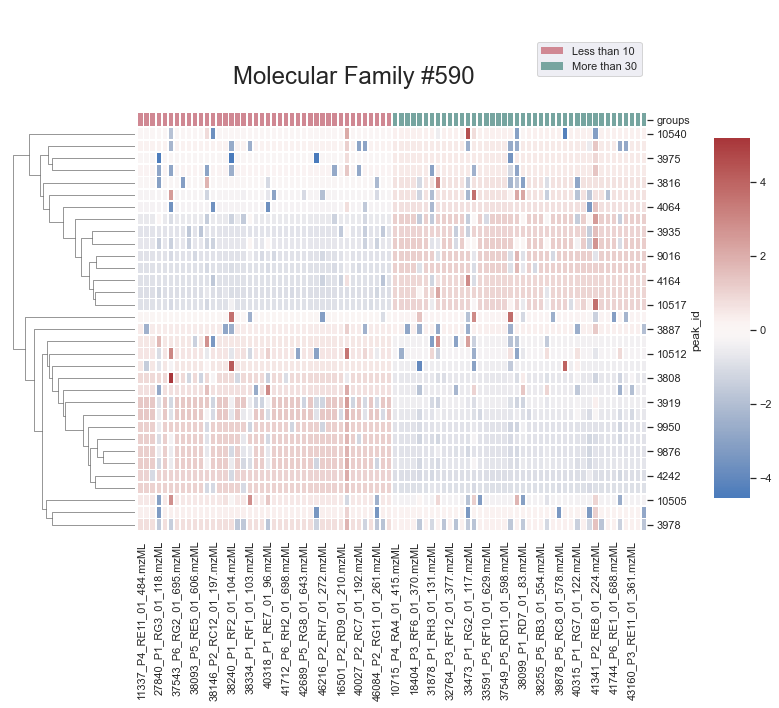

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3808,NaN,663.7398,7.3026,0.001831,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3816,NaN,707.7992,7.2025,0.002025,39,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3817,NaN,751.8591,7.1249,0.002048,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3843,NaN,795.9237,6.9916,0.002949,59,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3887,NaN,908.0022,8.9619,0.003925,27,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3892,NaN,863.9586,9.0506,0.003571,33,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3905,NaN,952.0464,8.8503,0.003342,19,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3919,NaN,839.9796,6.9296,0.002159,63,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3935,NaN,819.9163,9.1218,0.001864,19,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


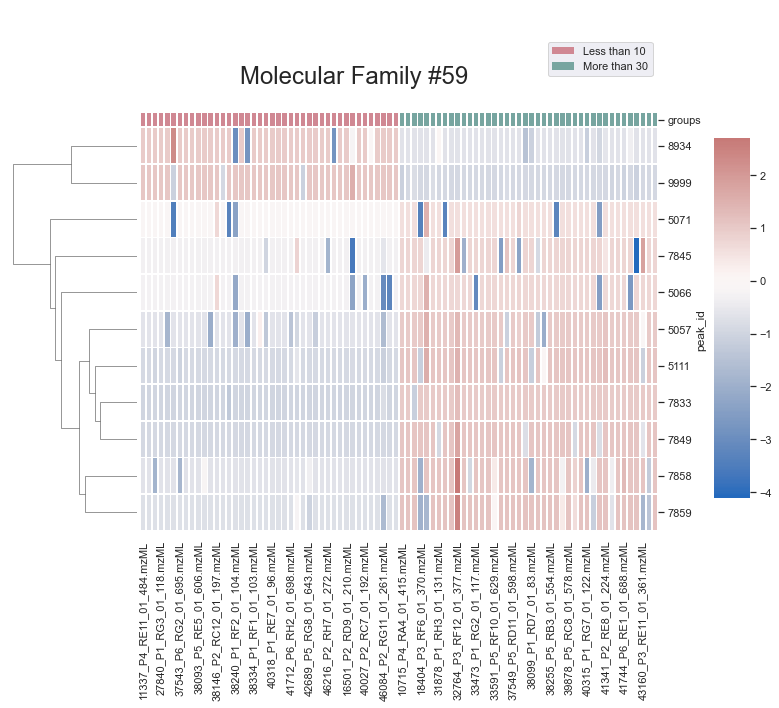

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
5057,NaN,365.4620,5.9674,0.001637,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5066,NaN,341.4517,6.4192,0.001204,20,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5071,NaN,359.4703,6.4355,0.001096,23,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5111,NaN,305.4152,5.9262,0.000421,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7833,NaN,341.3921,6.1926,0.000313,17,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7845,NaN,341.4519,6.0052,0.000909,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7849,NaN,343.4686,5.6526,0.000235,15,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7858,NaN,279.3522,5.7642,0.000191,48,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7859,NaN,339.4352,5.7274,0.000221,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


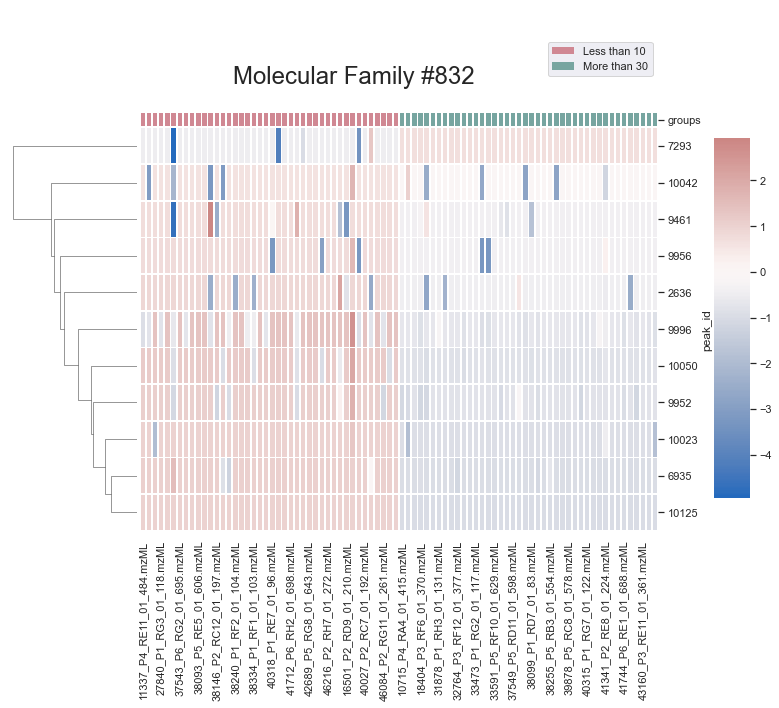

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2636,NaN,675.7456,7.9158,0.000269,18,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6935,NaN,369.4512,9.1608,0.000585,21,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7293,NaN,371.4604,9.3859,0.000321,13,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9461,NaN,399.4972,10.0221,0.000274,34,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9952,NaN,359.3697,4.9676,0.000482,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9956,NaN,369.4669,9.1684,0.000631,11,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9996,NaN,753.7594,4.9741,0.000245,63,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10023,NaN,357.3773,11.9117,0.000361,13,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10042,NaN,357.3778,10.1088,0.000391,32,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


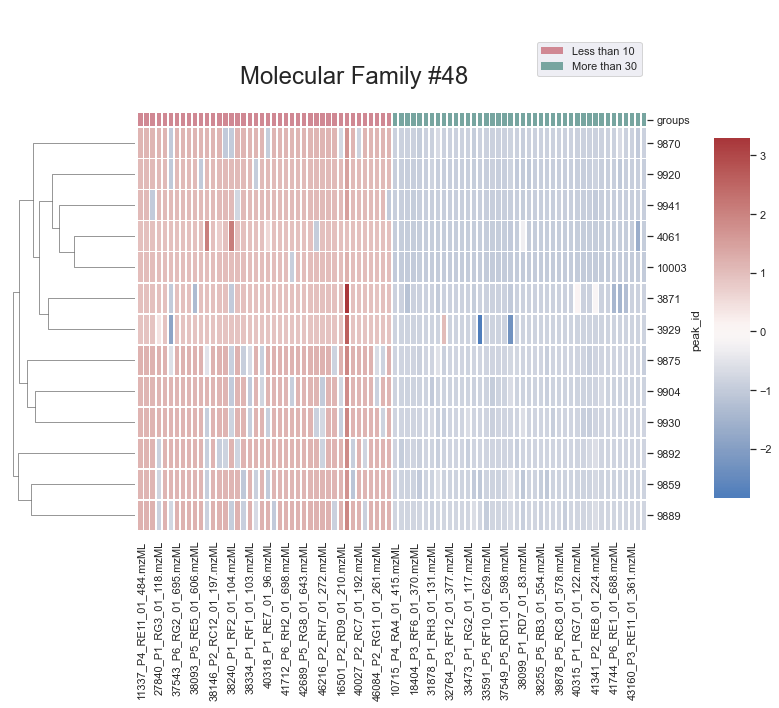

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3871,NaN,510.5121,5.4315,0.000435,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3929,NaN,466.4810,5.4928,0.000341,17,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4061,NaN,422.4590,5.5492,0.000200,17,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9859,NaN,642.6661,5.2958,0.001980,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9870,NaN,598.6326,5.3257,0.001816,48,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9875,NaN,686.7000,5.2621,0.001622,43,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9889,NaN,730.7342,5.2333,0.001298,39,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9892,NaN,554.5990,5.3815,0.001323,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9904,NaN,774.7675,5.2290,0.000983,39,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


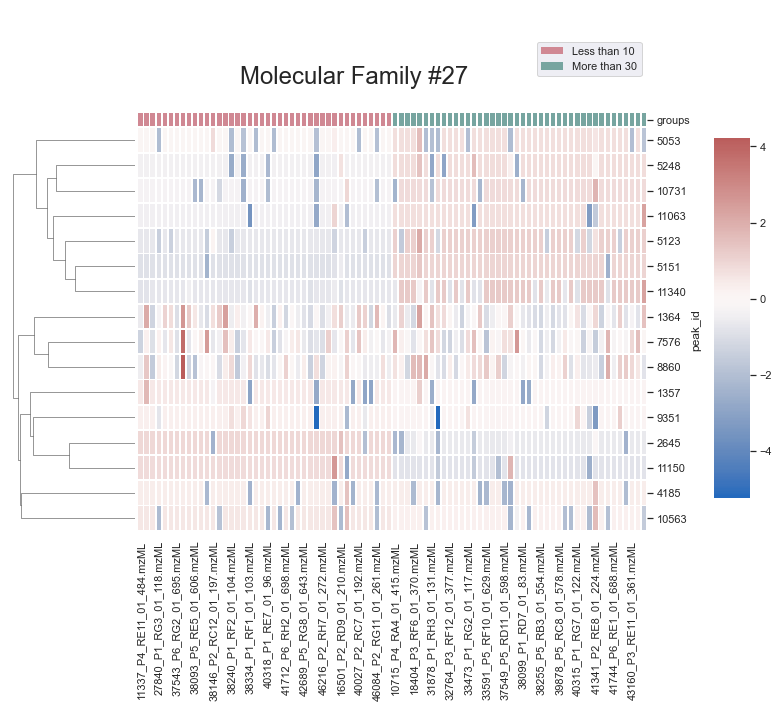

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1357,NaN,429.4796,8.9598,0.000371,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1364,NaN,349.2735,5.1751,0.002623,188,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2645,NaN,402.4495,8.5600,0.000871,23,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4185,NaN,416.5012,8.8460,0.000847,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5053,NaN,429.4930,8.3649,0.001981,32,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5123,NaN,894.0087,8.3469,0.000202,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5151,NaN,447.4955,8.7727,0.000223,10,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5248,NaN,429.4810,8.5614,0.000582,26,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7576,NaN,321.2415,4.7236,0.001353,197,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


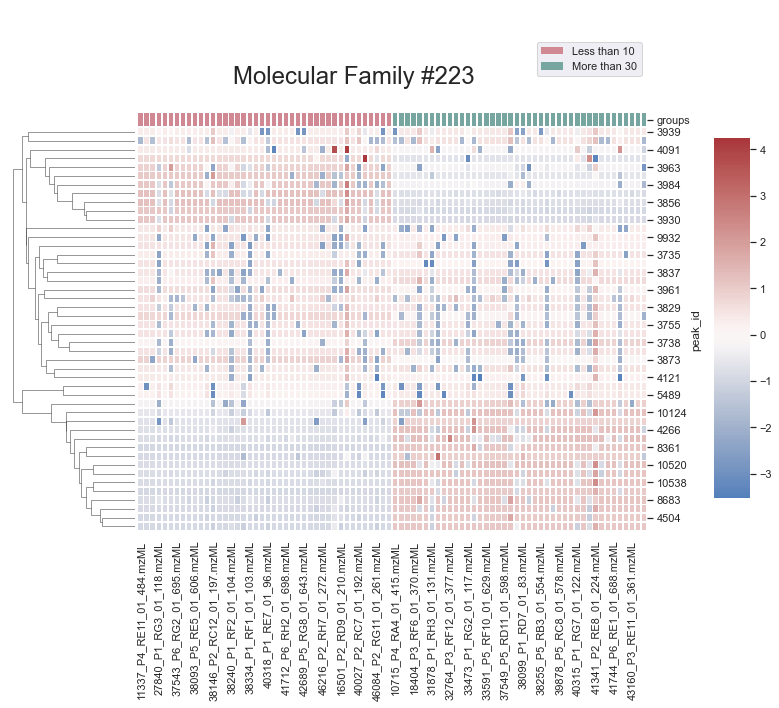

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3735,NaN,763.8089,8.2908,0.012190,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3738,NaN,807.8867,8.0880,0.008763,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3754,NaN,851.9422,8.0080,0.015307,51,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3755,NaN,719.7482,8.3015,0.010421,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3784,NaN,896.0010,7.9015,0.002197,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3829,NaN,675.7094,8.4248,0.004466,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3837,NaN,679.7860,6.7127,0.003670,57,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3847,NaN,767.8421,6.5011,0.004177,44,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3848,NaN,635.7509,6.7925,0.004568,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


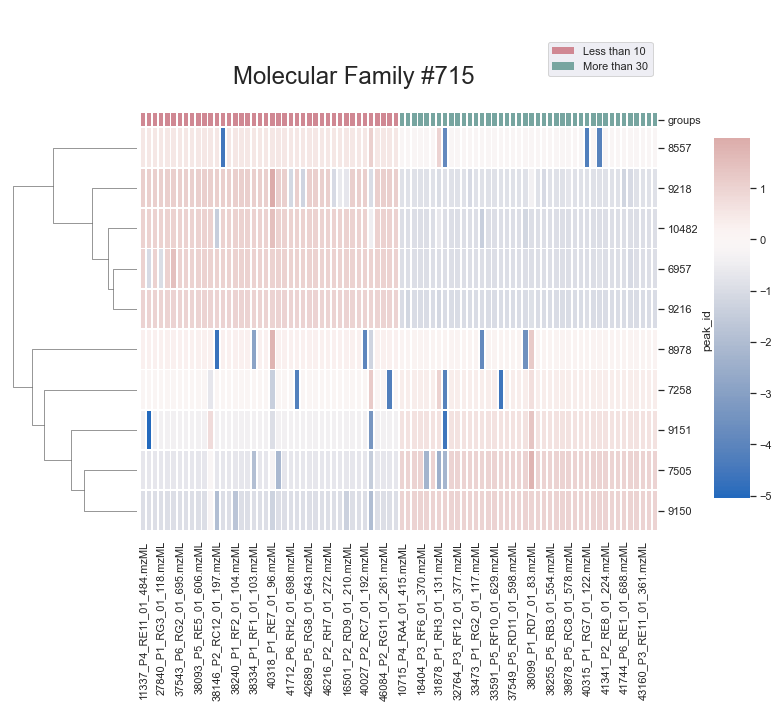

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
6957,NaN,841.8549,9.4373,0.000083,11,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7258,NaN,797.7574,9.7437,0.000548,20,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7505,NaN,841.7575,9.6884,0.000311,22,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8557,NaN,841.8161,9.4708,0.000220,15,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8978,NaN,797.7392,9.7529,0.000193,23,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9150,NaN,885.7712,9.6752,0.000188,16,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9151,NaN,841.7705,9.7285,0.000182,14,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9216,NaN,841.7275,9.6484,0.000197,16,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9218,NaN,885.7370,9.5943,0.000168,27,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


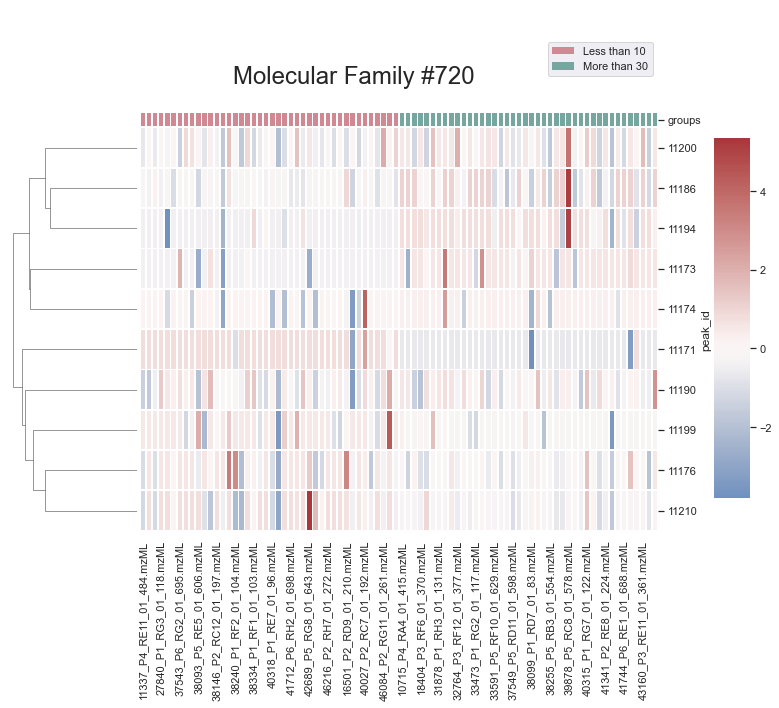

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
11171,NaN,239.1751,2.7067,0.000997,11,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11173,NaN,287.1757,2.9167,0.000952,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11174,NaN,253.1905,2.9347,0.000394,51,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11176,NaN,278.2225,2.6880,0.001062,109,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11186,NaN,352.2591,2.9175,0.000132,113,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11190,NaN,271.1479,2.7135,0.000620,172,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11194,NaN,350.2435,2.9460,0.000251,60,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11199,NaN,285.1603,2.7897,0.000213,76,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
11200,NaN,366.2749,3.0472,0.000148,139,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


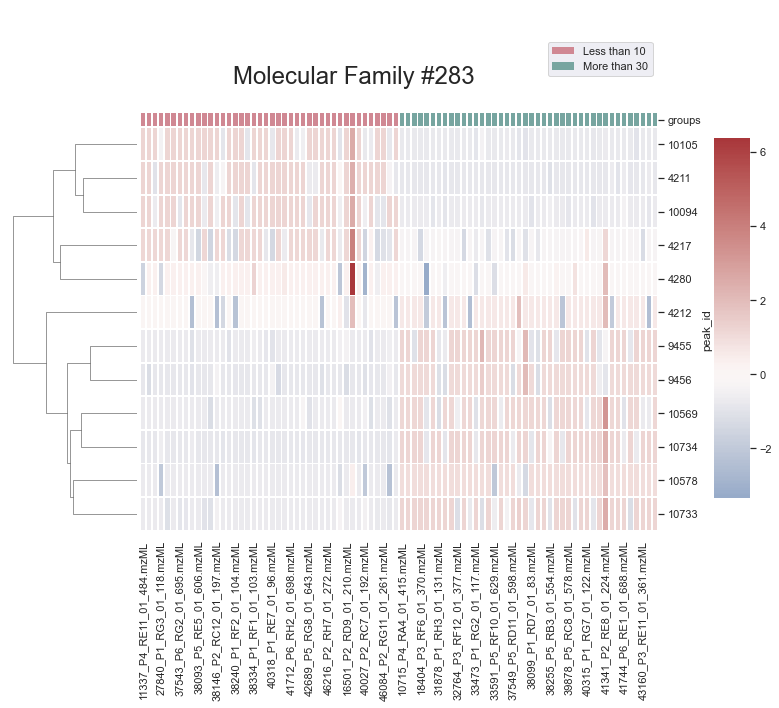

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
4211,NaN,783.8433,7.8543,0.000270,57,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4212,NaN,739.7983,7.9604,0.000157,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4217,NaN,827.8797,7.9097,0.000172,63,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4280,NaN,871.8631,7.6350,0.000111,56,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9455,NaN,739.7196,8.4946,0.000299,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
9456,NaN,783.7575,8.4317,0.000236,43,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10094,NaN,827.8925,7.7467,0.000114,57,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10105,NaN,871.9422,7.6653,0.000089,60,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10569,NaN,783.7977,7.8707,0.000114,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


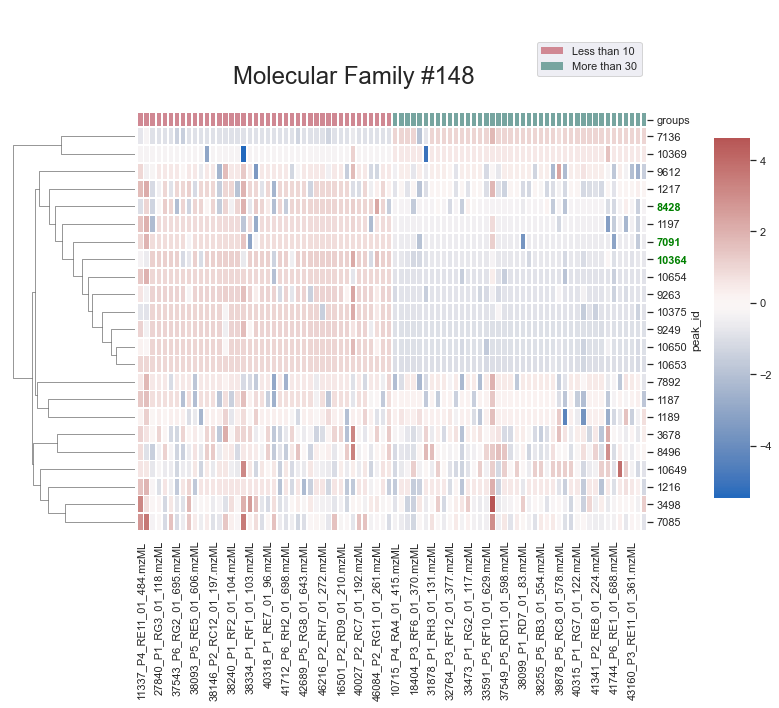

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1187,NaN,357.2056,3.0498,0.037737,61,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1189,NaN,385.2352,3.4066,0.005774,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1197,NaN,343.2264,3.6391,0.018462,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1216,NaN,367.2269,3.3133,0.003620,86,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1217,NaN,339.1964,3.0423,0.003786,109,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3498,NaN,769.4667,3.3526,0.001045,174,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3678,NaN,399.3253,5.7595,0.000823,159,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7085,NaN,713.4052,3.0489,0.003077,176,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7091,Spectral Match to Mestranol from NIST14,311.2008,3.0540,0.001190,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


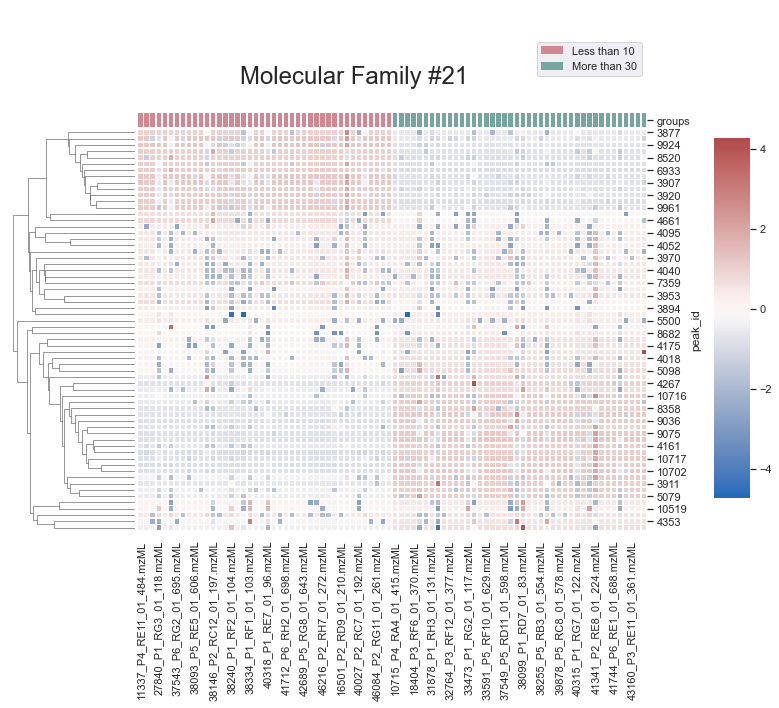

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3858,NaN,824.9181,8.0948,0.002805,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3877,NaN,768.8927,7.0942,0.001291,45,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3891,NaN,868.9746,8.0100,0.004681,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3894,NaN,780.8344,8.2712,0.002747,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3907,NaN,812.9570,7.0064,0.002116,43,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
...,...,...,...,...,...,...
10702,NaN,780.8562,8.1836,0.001228,42,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10708,NaN,912.9883,7.9054,0.000680,34,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10716,NaN,856.9589,6.9576,0.000258,48,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


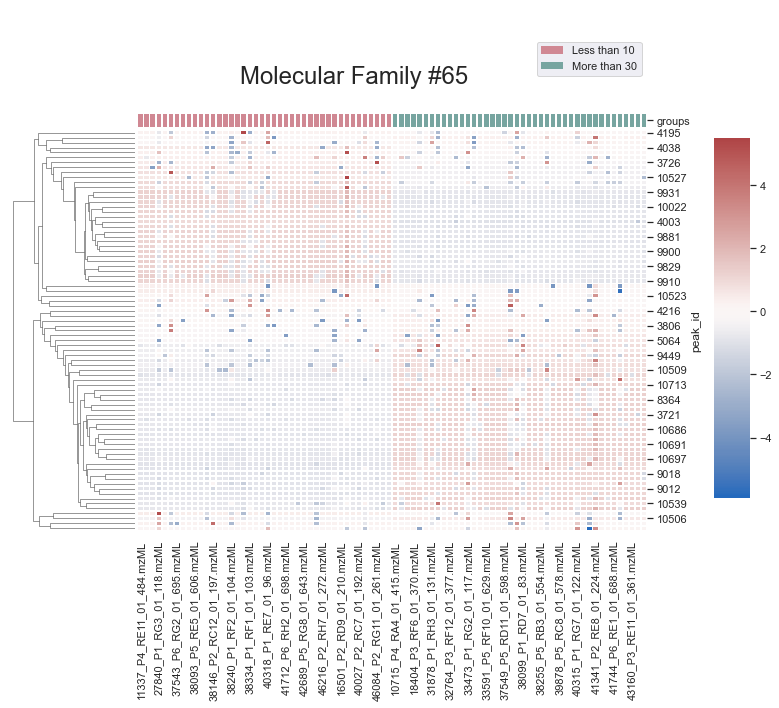

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3721,NaN,779.8108,7.7096,0.009204,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3726,NaN,735.8221,7.6932,0.004858,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3737,NaN,823.8721,7.5126,0.004360,27,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3747,NaN,691.7863,7.8109,0.006865,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3763,NaN,867.9288,7.4281,0.002934,25,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
...,...,...,...,...,...,...
10699,NaN,752.7429,7.7278,0.001035,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10700,NaN,840.7138,7.5213,0.000858,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10707,NaN,708.7456,7.7956,0.000525,43,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


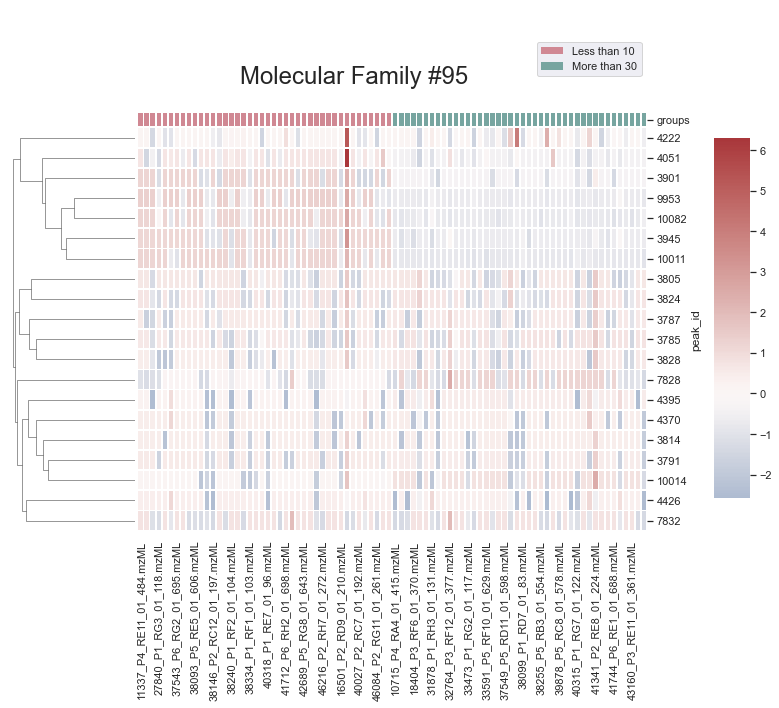

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3785,NaN,626.7526,5.9603,0.009756,87,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3787,NaN,670.7970,5.9141,0.009723,92,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3791,NaN,654.7902,6.6926,0.008627,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3805,NaN,714.8430,5.9429,0.008447,92,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3814,NaN,610.7522,6.7531,0.007130,55,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3824,NaN,758.8868,5.9179,0.006378,99,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3828,NaN,582.7077,6.0063,0.006512,71,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3901,NaN,846.9647,5.8355,0.001429,65,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3945,NaN,890.9936,5.7978,0.000402,58,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


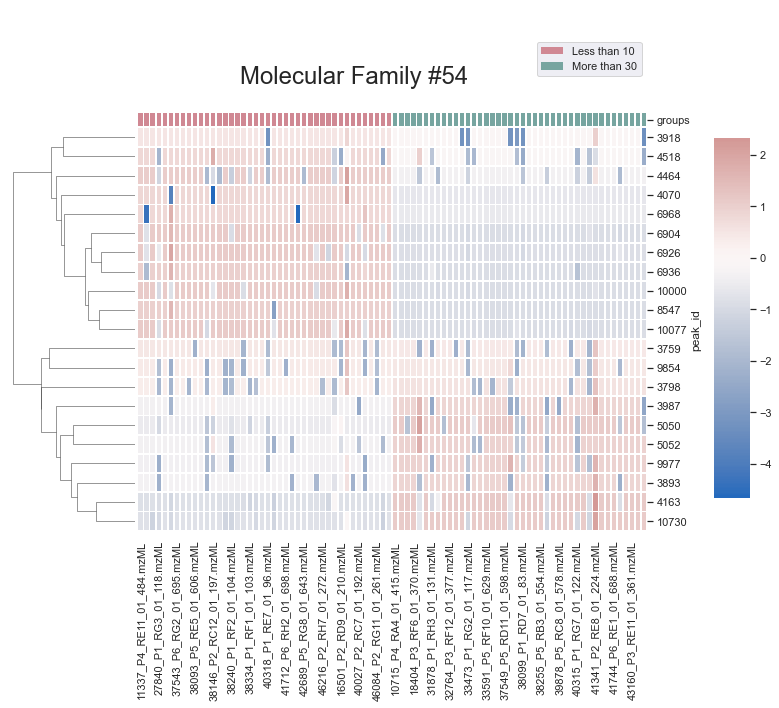

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3759,NaN,791.8889,8.6607,0.010841,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3798,NaN,747.8450,8.7658,0.006608,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3893,NaN,967.9785,8.3714,0.002147,34,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3918,NaN,703.8009,8.9042,0.002422,20,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3987,NaN,1012.0422,8.3632,0.001079,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4070,NaN,659.7575,9.0470,0.000566,12,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4163,NaN,1056.0958,8.1407,0.000283,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4464,NaN,879.9212,8.5877,0.003595,42,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4518,NaN,967.9999,8.4871,0.001684,42,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


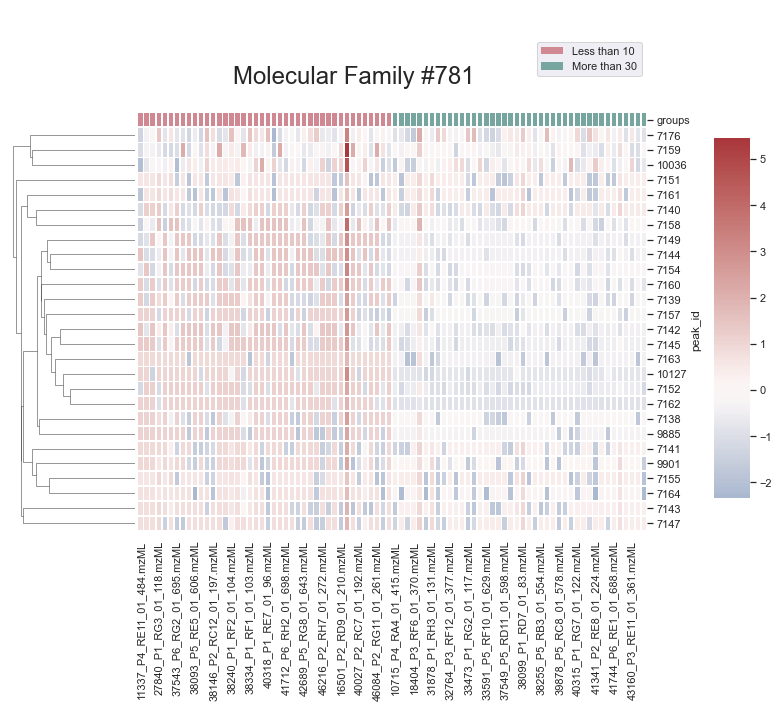

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
7138,NaN,582.6597,2.8030,0.000904,83,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7139,NaN,604.6841,2.8091,0.000915,81,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7140,NaN,560.6346,2.7715,0.003000,106,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7141,NaN,538.6105,2.7542,0.003149,79,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7142,NaN,626.7083,2.8047,0.001632,83,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7143,NaN,516.5857,2.7515,0.003144,75,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7144,NaN,670.7575,2.8144,0.000695,64,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7145,NaN,648.7330,2.8164,0.001067,73,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7147,NaN,494.5610,2.7598,0.002796,77,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


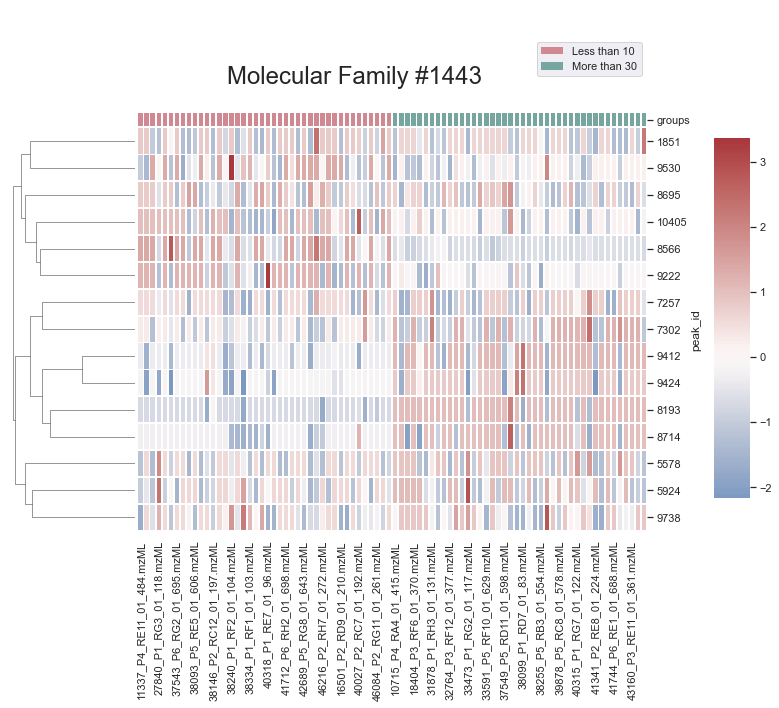

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1851,NaN,803.6620,10.0198,0.001578,86,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5578,NaN,891.7150,10.0141,0.000755,110,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5924,NaN,891.7151,11.9333,0.000645,121,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7257,NaN,847.6880,10.0184,0.000807,96,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7302,NaN,847.6889,11.9340,0.000648,102,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8193,NaN,1023.7914,9.2777,0.000182,32,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8566,NaN,803.6623,11.9676,0.000576,91,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8695,NaN,979.7679,9.1258,0.001705,130,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
8714,NaN,935.7437,9.4308,0.000093,53,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


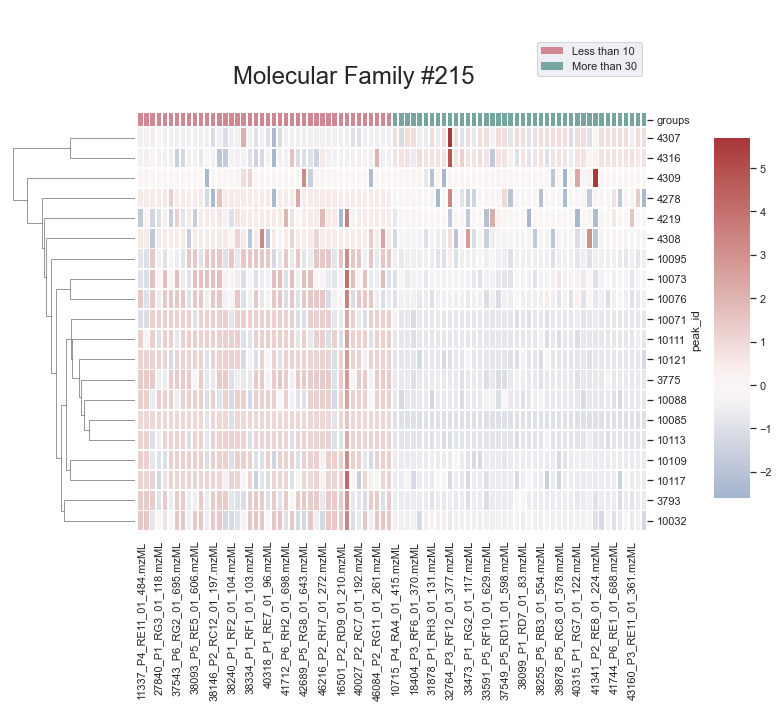

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3775,NaN,598.5550,5.1946,0.001786,71,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
3793,NaN,554.5304,5.2555,0.001443,62,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4219,NaN,675.6643,5.6903,0.000187,78,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4278,NaN,609.5593,5.6566,0.000104,57,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4307,NaN,609.5362,5.5858,0.000091,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4308,NaN,695.6183,5.6412,0.000091,71,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4309,NaN,523.5021,5.6943,0.000086,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4316,NaN,695.5920,5.5785,0.000103,96,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
10032,NaN,642.5886,5.0567,0.000205,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


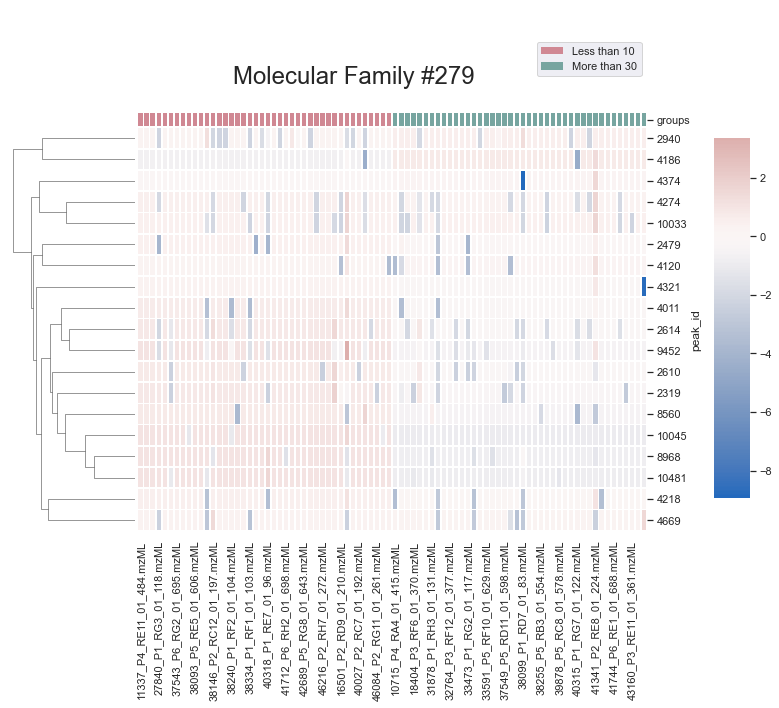

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2319,NaN,981.0494,10.0435,0.000848,31,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2479,NaN,937.0327,10.0495,0.001711,18,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2610,NaN,937.0335,8.2110,0.001251,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2614,NaN,937.0331,8.3959,0.001838,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2940,NaN,892.9661,10.0136,0.003514,50,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4011,NaN,937.0325,12.0036,0.002717,15,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4120,NaN,981.0692,10.0350,0.001822,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4186,NaN,1041.1431,9.2125,0.000429,6,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4218,NaN,848.9979,8.8443,0.001392,23,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


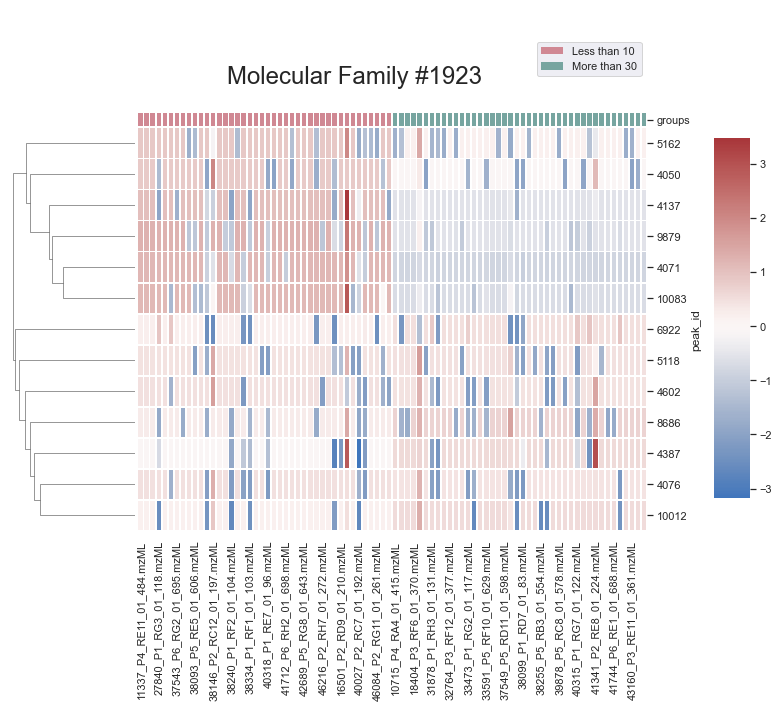

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
4050,NaN,808.8703,8.3088,0.000427,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4071,NaN,780.8884,7.7108,0.001933,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4076,NaN,764.8089,8.3142,0.003516,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4137,NaN,736.8543,7.8481,0.000177,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4387,NaN,845.8397,8.1370,0.000062,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4602,NaN,764.8285,8.4387,0.000719,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5118,NaN,852.9105,8.2037,0.000476,60,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5162,NaN,896.9441,8.2846,0.000523,57,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6922,NaN,897.0067,8.4236,0.001240,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


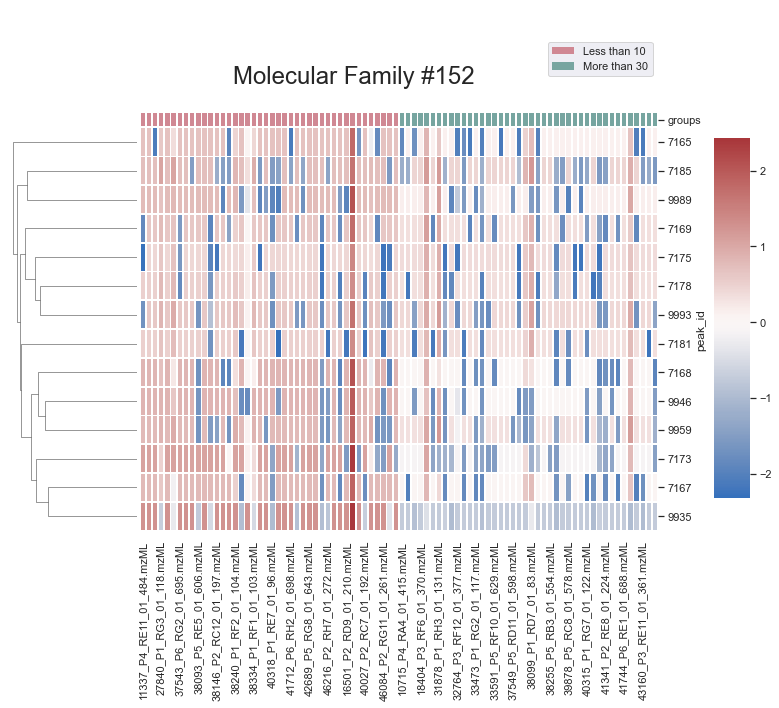

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
7165,NaN,527.5826,2.7579,0.001244,69,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7167,NaN,549.6079,2.7695,0.001040,63,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7168,NaN,571.6309,2.7776,0.000933,65,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7169,NaN,505.5584,2.7437,0.001239,75,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7173,NaN,593.6562,2.8196,0.000339,76,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7175,NaN,483.5334,2.7522,0.001494,60,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7178,NaN,461.5094,2.7361,0.001654,68,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7181,NaN,439.4845,2.7009,0.001456,66,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7185,NaN,459.0299,2.7087,0.001013,89,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


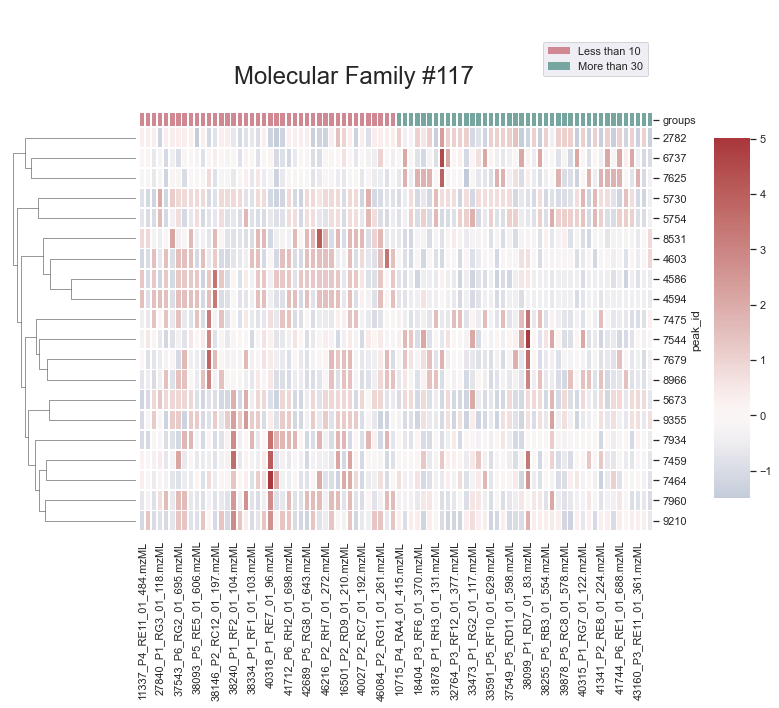

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2782,NaN,919.7461,7.7582,0.001555,84,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4586,NaN,963.7713,8.0343,0.000492,88,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4594,NaN,963.7712,7.9318,0.001076,95,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
4603,NaN,963.7714,8.2565,0.002977,100,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5673,NaN,847.6879,8.0866,0.001354,117,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5730,NaN,759.6349,8.5641,0.000500,114,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
5754,NaN,759.6344,8.7328,0.001553,124,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6737,NaN,831.6925,8.8127,0.002249,161,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7459,NaN,847.6881,8.5200,0.005594,178,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


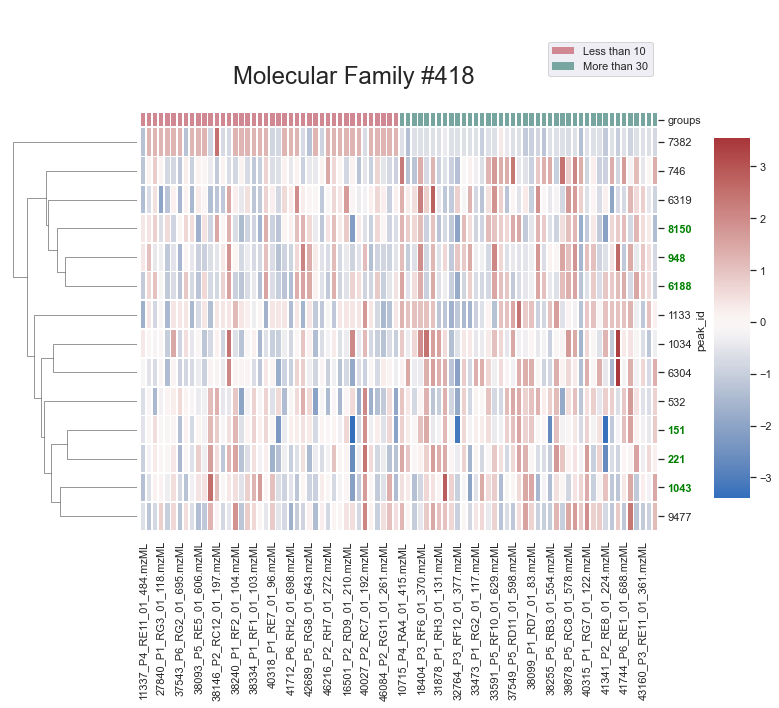

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
151,Spectral Match to Conjugated linoleic Acid (10...,281.2476,6.2586,0.031245,196,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
221,Spectral Match to Conjugated linoleic Acid (10...,281.2476,4.7609,0.012588,199,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
532,NaN,561.4880,6.2645,0.007503,169,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
746,NaN,563.5041,9.3284,0.001603,169,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
948,Spectral Match to Conjugated linoleic Acid (10...,281.2475,4.5345,0.015348,199,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1034,NaN,299.2585,4.5934,0.003355,195,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1043,Spectral Match to Conjugated linoleic Acid (10...,281.2475,6.4837,0.006479,197,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
1133,NaN,563.5039,9.5319,0.000742,108,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
6188,Spectral Match to Conjugated linoleic Acid (10...,281.2473,6.0507,0.030882,194,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


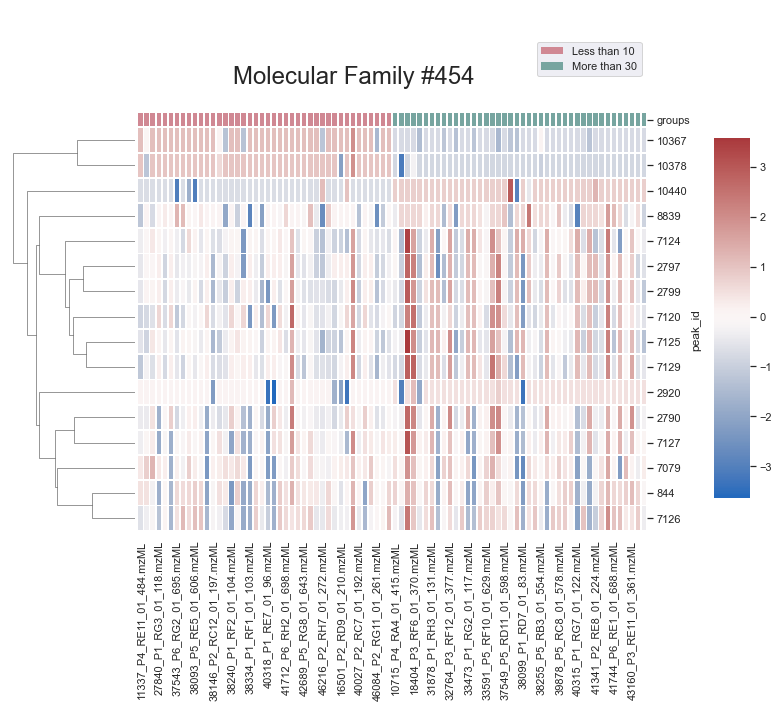

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
844,NaN,144.9819,12.7340,0.022750,193,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2790,NaN,144.9823,12.2434,0.021566,179,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2797,NaN,144.9822,8.6315,0.006855,161,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2799,NaN,144.9823,8.4830,0.005518,163,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
2920,NaN,145.0175,9.9493,0.005275,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7079,NaN,144.9823,12.8169,0.009585,190,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7120,NaN,144.9822,12.0817,0.003241,167,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7124,NaN,144.9823,11.5888,0.003472,166,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...
7125,NaN,144.9822,11.7222,0.002225,162,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?vi...


In [48]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
                
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RTConsensus']
        mz = member_info['precursor mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))
    plt.suptitle('%s' % (pw_name), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    plt.show()
    display(member_df)

array(['7091', '8428', '10364'], dtype=object)